<a href="https://colab.research.google.com/github/vaishnavij20/Text-classification-from-scratch/blob/main/Text_classifier_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import pandas as pd
import re

from google.colab import drive
drive.mount('/content/drive')

# Function to clean text
def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^a-zA-Z0-9\s]", '', text)
    return text

# Path to the IEMOCAP dataset directory
dataset_path = "/content/drive/MyDrive/Text Classification Project/IEMOCAP_full_release"

# Lists to store data
texts = []
labels = []

# Iterate over the dataset files
for session in range(1, 6):
    session_path = os.path.join(dataset_path, f'Session{session}', 'dialog', 'transcriptions')
    for root, _, files in os.walk(session_path):
        for file in files:
            if file.endswith('.txt'):
                with open(os.path.join(root, file), 'r') as f:
                    for line in f:
                        parts = line.strip().split(' ')
                        label = parts[0]
                        text = ' '.join(parts[1:])
                        texts.append(clean_text(text))
                        labels.append(label)

# Create a DataFrame
df = pd.DataFrame({'text': texts, 'label': labels})

# Save to CSV
csv_file_path = "iemocap_dataset.csv"
df.to_csv(csv_file_path, index=False)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import re

# Use a raw string for the file path to handle backslashes correctly
csv_path = "iemocap_dataset.csv"

# Load the CSV file into a DataFrame
df = pd.read_csv(csv_path)

# Function to remove numbers from the beginning of the text
def remove_leading_numbers(text):
    # Ensure the text is a string
    if isinstance(text, str):
        return re.sub(r'^\d+\s*', '', text)
    else:
        return text

# Convert all entries in the 'text' column to strings
df['text'] = df['text'].astype(str)

# Apply the function to the 'text' column
df['text'] = df['text'].apply(remove_leading_numbers)

# Save the cleaned DataFrame to a new CSV file
df.to_csv('cleaned_file.csv', index=False)

print("Numbers removed and new CSV file saved as 'cleaned_file.csv'.")


Numbers removed and new CSV file saved as 'cleaned_file.csv'.


Getting a pretrained model for label analysis using transformors

In [ ]:
!pip install transformers
!pip install torch


  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21

Adding labels to dataset: In this dataset is given in some chunks so that it'll add labels quickly

In [ ]:
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import matplotlib.pyplot as plt
import seaborn as sns

# Load pre-trained model and tokenizer
model_name = "bhadresh-savani/distilbert-base-uncased-emotion"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/291 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/768 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/268M [00:00<?, ?B/s]

Output files are created for each chunk/file.

In [ ]:
# Load the cleaned text file into a DataFrame
data = pd.read_csv('/content/clean_text_05.txt', delimiter=',', names=['text'])

# Tokenize and classify the text
def classify_text(text):
    inputs = tokenizer(text, return_tensors='pt')
    outputs = model(**inputs)
    probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
    return torch.argmax(probs, dim=-1).item()

# Apply classification to each text in the dataset
data['label'] = data['text'].apply(classify_text)

# Map label ids to label names (adjust this mapping according to your model's labels)
label_map = {0: 'neutral', 1: 'surprise', 2: 'sadness', 3: 'joy', 4: 'disgust', 5: 'anger', 6: 'fear' }
data['label'] = data['label'].map(label_map)

# Display the first few rows of the dataset
print(data.head())

In [ ]:
# Save the DataFrame to a CSV file
output_file = 'sentiment_01.txt'  # Replace with your desired output file name
data.to_csv(output_file, index=False)

Distilbert-dataset.csv is the file created by adding all labeled subfiles together

Plotting the labeled-dataset.csv

label
surprise    4638
joy         4220
neutral      842
disgust      324
sadness      142
anger         62
label          4
Name: count, dtype: int64


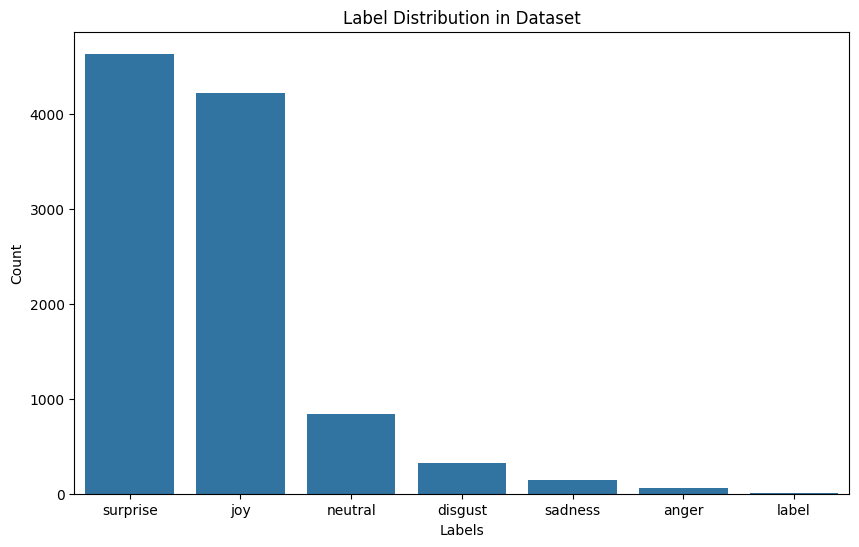

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
!pip install seaborn
import seaborn as sns

data = pd.read_csv('/content/Distilbert-dataset.csv')
# Label Distribution
label_counts = data['label'].value_counts()
print(label_counts)

# Plot Label Distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='label', data=data, order=label_counts.index)
plt.title('Label Distribution in Dataset')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.show()

Label is extra added somehow on x-axis which will be removed further which is of no use.

Tokenized text data and converted it into sequences and saved in preprocessed_data.csv file

In [ ]:
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Load your labeled data
data = pd.read_csv('/content/Distilbert-dataset.csv')

# Remove invalid labels (NaNs and unexpected labels)
valid_labels = ['neutral','surprise', 'sadness', 'joy', 'disgust', 'anger', 'fear']
data = data.dropna(subset=['label'])
data = data[data['label'].isin(valid_labels)]

# Tokenize the text data
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(data['text'])

# Convert text to sequences
sequences = tokenizer.texts_to_sequences(data['text'])

# Pad the sequences
padded_sequences = pad_sequences(sequences, padding='post')

# Encode the labels
label_encoder = LabelEncoder()
label_encoded = label_encoder.fit_transform(data['label'])

# Convert the padded sequences to a DataFrame
padded_df = pd.DataFrame(padded_sequences)

# Combine the padded sequences and labels into one DataFrame
combined_df = pd.concat([padded_df, pd.Series(label_encoded, name='label')], axis=1)

# Save the combined DataFrame to a CSV file
combined_df.to_csv('/content/preprocessed_data.csv', index=False)

print("Preprocessed data saved to 'preprocessed_data.csv'.")


Preprocessed data saved to 'preprocessed_data.csv'.


Data splitting

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
import matplotlib.pyplot as plt

# Load the preprocessed data
data = pd.read_csv('/content/preprocessed_data.csv')

# Separate features (text sequences) and labels
X = data.drop(columns=['label']).values
y = data['label'].values

# One-hot encode the labels
num_classes = len(np.unique(y))
y = to_categorical(y, num_classes=num_classes)

# Split the data into training and remaining sets (80% train, 20% remaining)
X_train, X_remaining, y_train, y_remaining = train_test_split(X, y, test_size=0.2, random_state=42)

# Split the remaining data into validation and test sets (50% validation, 50% test)
X_val, X_test, y_val, y_test = train_test_split(X_remaining, y_remaining, test_size=0.5, random_state=42)

# Print the shapes of the resulting datasets
print(f"Training set: {X_train.shape}, {y_train.shape}")
print(f"Validation set: {X_val.shape}, {y_val.shape}")
print(f"Test set: {X_test.shape}, {y_test.shape}")


Training set: (8182, 100), (8182, 6)
Validation set: (1023, 100), (1023, 6)
Test set: (1023, 100), (1023, 6)


Defined CNN model with following layers and compiled it

In [ ]:
# Define the CNN model
vocab_size = 10000  # Should be the same as used in the tokenizer
embedding_dim = 128
max_length = X_train.shape[1]  # The maximum length of sequences

model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
    Conv1D(filters=128, kernel_size=5, activation='relu'),
    GlobalMaxPooling1D(),
    Dropout(0.5),  # Add dropout after the pooling layer
    Dense(64, activation='relu'),
    Dropout(0.5),  # Add another dropout layer before the output layer
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


Training of model using train , validation data

In [ ]:
# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))


Epoch 1/10
256/256 [==============================] - 18s 65ms/step - loss: 1.1338 - accuracy: 0.5306 - val_loss: 0.8355 - val_accuracy: 0.7097
Epoch 2/10
256/256 [==============================] - 20s 79ms/step - loss: 0.7413 - accuracy: 0.7501 - val_loss: 0.5900 - val_accuracy: 0.7840
Epoch 3/10
256/256 [==============================] - 18s 69ms/step - loss: 0.4930 - accuracy: 0.8373 - val_loss: 0.5320 - val_accuracy: 0.8133
Epoch 4/10
256/256 [==============================] - 17s 65ms/step - loss: 0.3734 - accuracy: 0.8806 - val_loss: 0.5428 - val_accuracy: 0.8260
Epoch 5/10
256/256 [==============================] - 17s 65ms/step - loss: 0.2925 - accuracy: 0.9031 - val_loss: 0.5573 - val_accuracy: 0.8358
Epoch 6/10
256/256 [==============================] - 17s 65ms/step - loss: 0.2395 - accuracy: 0.9219 - val_loss: 0.5885 - val_accuracy: 0.8387
Epoch 7/10
256/256 [==============================] - 17s 65ms/step - loss: 0.1935 - accuracy: 0.9395 - val_loss: 0.6212 - val_accuracy:

Plotting model performance

In [ ]:
# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy}')

32/32 [==============================] - 0s 13ms/step - loss: 0.8383 - accuracy: 0.8260
Test Accuracy: 0.8260019421577454


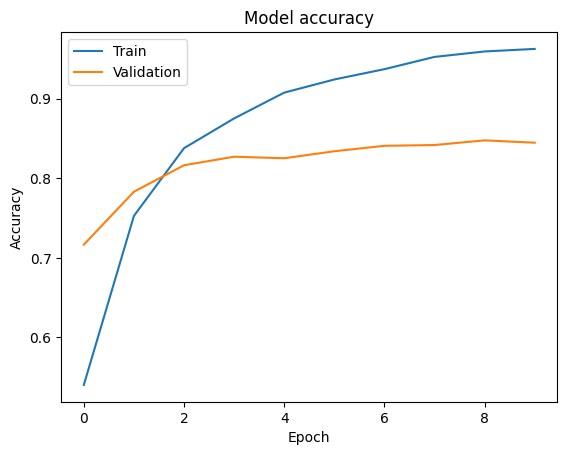

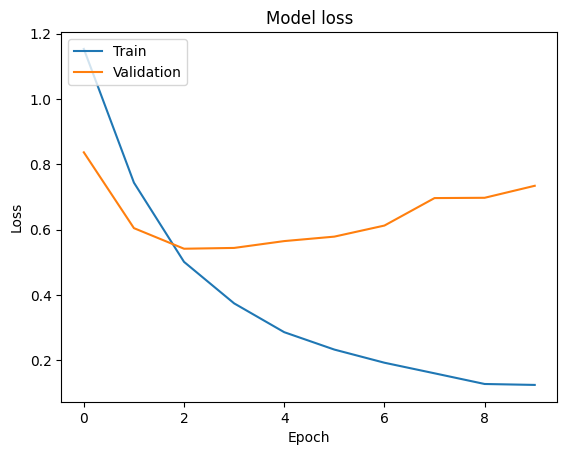

In [ ]:
import matplotlib.pyplot as plt
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

32/32 [==============================] - 1s 21ms/step


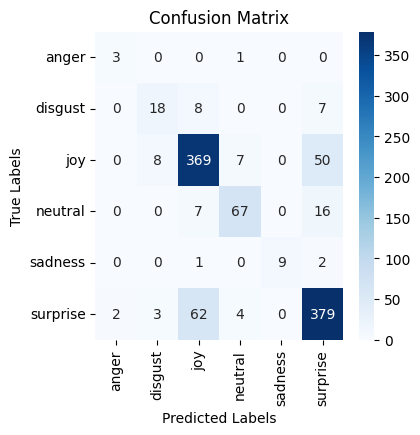

              precision    recall  f1-score   support

       anger       0.60      0.75      0.67         4
     disgust       0.62      0.55      0.58        33
         joy       0.83      0.85      0.84       434
     neutral       0.85      0.74      0.79        90
     sadness       1.00      0.75      0.86        12
    surprise       0.83      0.84      0.84       450

    accuracy                           0.83      1023
   macro avg       0.79      0.75      0.76      1023
weighted avg       0.83      0.83      0.83      1023



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# Predict the labels for the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

# Plot the confusion matrix
import seaborn as sns

plt.figure(figsize=(6, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Print the classification report
print(classification_report(y_true_classes, y_pred_classes, target_names=label_encoder.classes_))
